## 兩個任務

+ ### Analyze the results under different number of digits, training epoch, training size, etc
+ ### Can we apply the same training approach for multiplication?



### 這裡主要以 Combine adder and subtractor 版爲例進行實驗，分析不同條件下的實驗結果

In [1]:
from keras.models import Sequential
from keras import layers
from keras.layers import BatchNormalization
from keras.optimizers import Adam
import numpy as np
from six.moves import range

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# Parameters Config

In [3]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [4]:
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
    
    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[i] for i in x)

# Data Generation

In [5]:
def gen_data(size, op, max_len, digits, reverse=False):
    if op not in '+-*':
        raise Exception("Only supprt '+', '-' and '*' operations")
    questions = []
    expected = []
    seen = set()
    if op == '*':
        ans_len = digits + digits
    else:
        ans_len = digits + 1
    while len(questions) < size:
        f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, digits + 1))))
        a, b = f(), f()
        key = tuple(sorted((a, b)))
        if key in seen:
            continue
        seen.add(key)
        if op == '-' and a < b:
            a, b = b, a
        q = '{}{}{}'.format(a, op, b)
        query = q + ' ' * (max_len - len(q))
        ans = str(eval(q))
        ans += ' ' * (ans_len - len(ans))
        if reverse:
            query = query[::-1]
        questions.append(query)
        expected.append(ans)
    return questions, expected

# Processing

In [6]:
def vectorization(questions, expected, ctable, max_len, digits, output_len):
    x = np.zeros((len(questions), max_len, len(chars)), dtype=np.bool)
    y = np.zeros((len(expected), output_len, len(chars)), dtype=np.bool)
    for i, sentence in enumerate(questions):
        x[i] = ctable.encode(sentence, max_len)
    for i, sentence in enumerate(expected):
        y[i] = ctable.encode(sentence, output_len)
    return x, y

In [7]:
def train_test_split(x, y):
    indices = np.arange(len(y))
    np.random.shuffle(indices)
    x = x[indices]
    y = y[indices]

    # train_test_split
    split_at = len(y) - len(y)//10
    x_train = x[:split_at]
    y_train = y[:split_at]
    x_val = x[split_at:]
    y_val = y[split_at:]

    print('Training Data:')
    print(x_train.shape)
    print(y_train.shape)

    print('Testing Data:')
    print(x_val.shape)
    print(y_val.shape)

    return x_train, x_val, y_train, y_val

# Model defination


### 嘗試在原始模型中，LSTM 垂直方向都加入 BatchNormalization，目測發現效果很不錯，尤其三種情況都明顯加速收斂速度。

|Type|Without BatchNormalization|With BatchNormalization|
|--|--|--|
|**Adder**|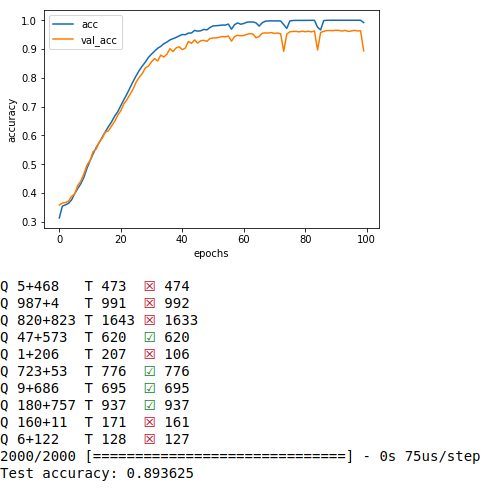|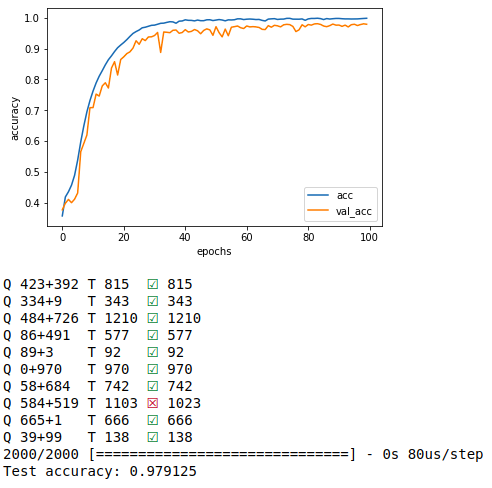|
|**Subtractor**|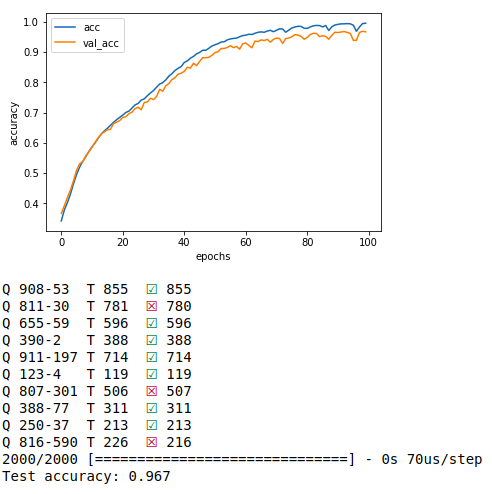|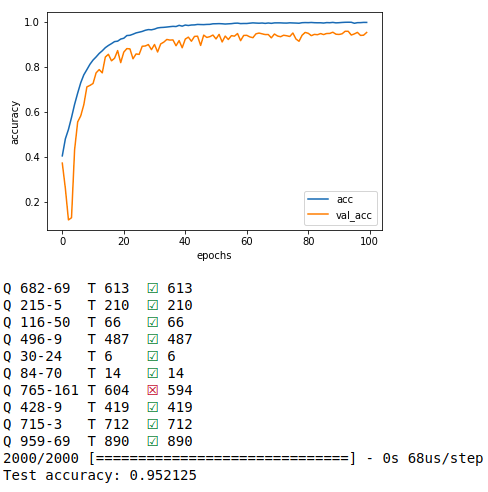|
|**Combine**|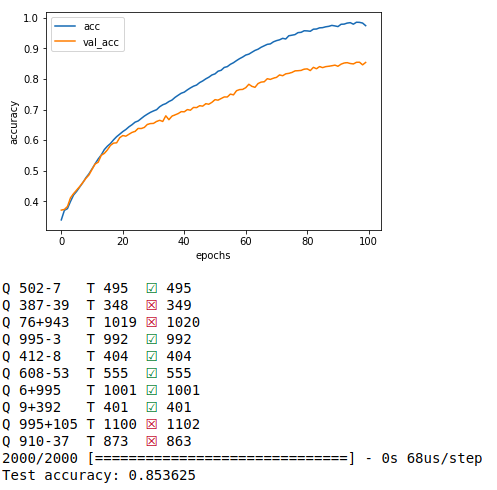|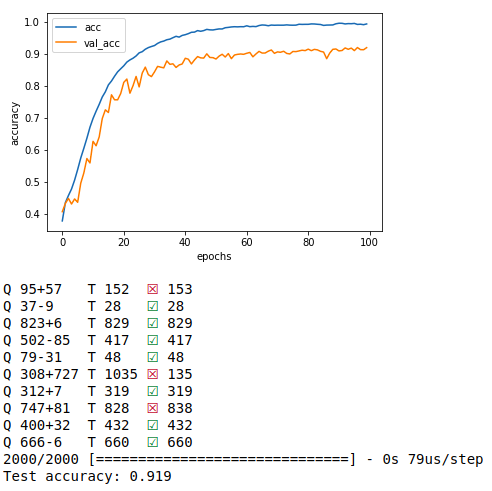|

In [8]:
def build_model(hidden_size, max_len, digits, chars, output_len, rnn=layers.LSTM):
    print('Build model...')

    model = Sequential()
    model.add(rnn(hidden_size, input_shape=(max_len, len(chars))))
    
    model.add(BatchNormalization())
    model.add(layers.RepeatVector(output_len))
    model.add(rnn(hidden_size, return_sequences=True))
    model.add(BatchNormalization())
    model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()
    return model

# Training

In [9]:
def train(model, x_train, x_val, y_train, y_val, epochs, batch_size=128, verbose=0):
    return model.fit(x_train,
                     y_train,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_data=(x_val, y_val),
                     verbose=verbose)

def do_plot(result, colors=None):
    accs = ['acc', 'val_acc']
    if colors is None:
        for acc in accs:
            plt.plot(result.history[acc])
    else:
        for acc, color in zip(accs, colors):
            plt.plot(result.history[acc], color=color)
    plt.xlabel('epochs')
    plt.ylabel('accuracy')

def plot_result(result):
    do_plot(result)
    plt.legend(['acc', 'val_acc'])
    plt.show()
    
def plot_results(results, colorss):
    legend = []
    for (tag, result), colors in zip(results, colorss):
        do_plot(result, colors)
        legend += list(map(lambda x: '{} {}'.format(tag, x),['acc', 'val_acc']))
    plt.legend(legend)
    plt.show()
    
    
def accuracy(model, x_val, y_val):
    return model.evaluate(x_val, y_val)[1]

def result_sampling(model, x_val, y_val, ctable, num_sample=10, reverse=False):
    for i in range(num_sample):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if reverse else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)

## 1. Different number of digits 

### Train

In [10]:
results = []
for digits in range(2, 6):
    chars = '0123456789+- '
    ctable = CharacterTable(chars)
    # digits = 3
    max_len = digits + 1 + digits
    output_len = digits + 1
    epochs = 100
    hidden_size = 128
    data_size = 10000 if digits == 2 else 20000

    xs_add, ys_add = gen_data(data_size//2, '+', max_len, digits)
    xs_sub, ys_sub = gen_data(data_size//2, '-', max_len, digits)
    xs = xs_add + xs_sub
    ys = ys_add + ys_sub
    xs, ys = vectorization(xs, ys, ctable, max_len, digits, output_len)
    x_train, x_val, y_train, y_val = train_test_split(xs, ys)
    

    model = build_model(hidden_size=hidden_size, max_len=max_len, digits=digits, chars=chars, output_len=output_len)
    result = train(model, x_train, x_val, y_train, y_val, epochs)
    tag = '{} digits'.format(digits)
    results.append((tag, result))
    print('{} training done!'.format(tag))

Training Data:
(9000, 5, 13)
(9000, 3, 13)
Testing Data:
(1000, 5, 13)
(1000, 3, 13)
Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               72704     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 3, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 128)            131584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 3, 128)            512       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 3, 13)             1677      
Total params: 206,989
Trainable params: 20

### Analysis

#### Accuracy of different number of digits against training epochs

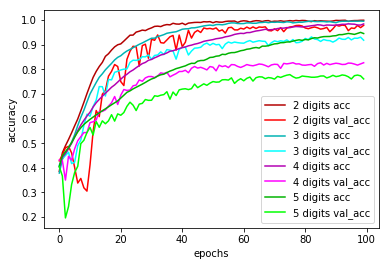

In [11]:
colorss = (((0.7,0,0),(1,0,0)),((0,0.7,0.7),(0,1,1)),((0.7,0,0.7),(1,0,1)),((0,0.7,0),(0,1,0)))
plot_results(results, colorss)

### 可以看到隨着 numbers of digits 的增加，train_acc 和 val_acc 都在下降。
**符合一開始的直覺，位數約多的加減法難度越高。**


**（顏色規律：同色系爲一組，淺色爲 val_acc）**

## 2. Different training size

這裡挑了上面 4 digits 的設定進一步做實驗

### Train

In [12]:
results = []
for data_size in [20000, 40000, 60000]:
    chars = '0123456789+- '
    ctable = CharacterTable(chars)
    digits = 4
    output_len = digits + 1
    epochs = 100
    hidden_size = 128
    # data_size = 20000

    xs_add, ys_add = gen_data(data_size//2, '+', max_len, digits)
    xs_sub, ys_sub = gen_data(data_size//2, '-', max_len, digits)
    xs = xs_add + xs_sub
    ys = ys_add + ys_sub
    xs, ys = vectorization(xs, ys, ctable, max_len, digits, output_len)
    x_train, x_val, y_train, y_val = train_test_split(xs, ys)

    model = build_model(hidden_size=hidden_size, max_len=max_len, digits=digits, chars=chars, output_len=output_len)
    result = train(model, x_train, x_val, y_train, y_val, epochs)
    tag = '{} data size'.format(data_size)
    results.append((tag, result))
    print('{} training done!'.format(tag))

Training Data:
(18000, 11, 13)
(18000, 5, 13)
Testing Data:
(2000, 11, 13)
(2000, 5, 13)
Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 128)               72704     
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512       
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 5, 128)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 5, 128)            131584    
_________________________________________________________________
batch_normalization_10 (Batc (None, 5, 128)            512       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 5, 13)             1677      
Total params: 206,989
Trainable params

### Analysis

#### Accuracy of different number of digits against training epochs

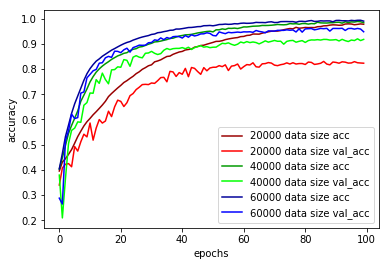

In [13]:
colorss = (((0.6,0,0),(1,0,0)),((0,0.6,0),(0,1,0)),((0,0,0.6),(0,0,1)))
plot_results(results, colorss)

20000 data size 的版本明顯 **overfitting** 的情況較嚴重，而條件允許下增加 data size 是解決 overfitting 的一個很好的方法。


這裡發現實驗設計上的疏忽：在 epochs 軸上**直接比較不同 data size 的 acc 是沒有意義的**，因爲 data size 越大，一個 epoch 會 train 越多 batch。

但從上圖還是可以明顯看到，20000 data size 在 60 epoch 和 60000 data size 在 20 epoch 相比，兩者的 train_acc 沒明顯差異，而後者的 val_acc 明顯高於前者，這表示 overfitting 的情況被改善了。

## 3. Same training approach for multiplication

In [14]:
chars = '0123456789* '
ctable = CharacterTable(chars)
digits = 3
max_len = digits + 1 + digits
output_len = digits + digits
epochs = 80
hidden_size = 128
data_size = 80000

xs, ys = gen_data(data_size, '*', max_len, digits)
print(xs[:4], ys[:4])
xs, ys = vectorization(xs, ys, ctable, max_len, digits, output_len)
x_train, x_val, y_train, y_val = train_test_split(xs, ys)


model = build_model(hidden_size=hidden_size, max_len=max_len, digits=digits, chars=chars, output_len=output_len)
result = train(model, x_train, x_val, y_train, y_val, epochs, verbose=0)
tag = '{} data size'.format(data_size)
results.append((tag, result))

['384*106', '13*706 ', '269*54 ', '159*1  '] ['40704 ', '9178  ', '14526 ', '159   ']
Training Data:
(72000, 7, 12)
(72000, 6, 12)
Testing Data:
(8000, 7, 12)
(8000, 6, 12)
Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 128)               72192     
_________________________________________________________________
batch_normalization_15 (Batc (None, 128)               512       
_________________________________________________________________
repeat_vector_8 (RepeatVecto (None, 6, 128)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 6, 128)            131584    
_________________________________________________________________
batch_normalization_16 (Batc (None, 6, 128)            512       
_________________________________________________________________
time_distributed_8 (

Q 97*757  T 73429  ☒ 73629 
Q 78*189  T 14742  ☒ 14142 
Q 85*87   T 7395   ☑ 7395  
Q 299*55  T 16445  ☒ 16245 
Q 289*737 T 212993 ☒ 211493
Q 50*487  T 24350  ☑ 24350 
Q 186*583 T 108438 ☒ 108038
Q 29*0    T 0      ☑ 0     
Q 225*562 T 126450 ☒ 124150
Q 73*33   T 2409   ☑ 2409  


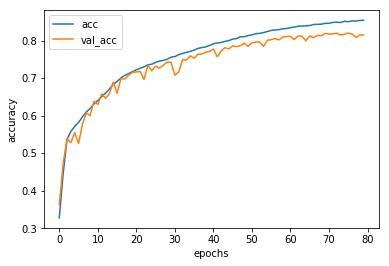

In [15]:
result_sampling(model, x_val, y_val, ctable)
plot_result(result)

**目測是 train 得起來的，只是需要更多 data 和 training epoch**